<a href="https://colab.research.google.com/github/khodid/2020_SAI_MONING2/blob/master/RNN_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

패키지 불러오기

In [7]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


Cloning into 'PyTorch'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1899 (delta 0), reused 0 (delta 0), pack-reused 1898
Receiving objects: 100% (1899/1899), 80.33 MiB | 40.03 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [8]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [0]:
# 데이터를 0, 1 사이의 값으로 mapping 해 줌. 네트워크 입장에선 scale을 학습의 대상에서 제외하여, 학습의 부담을 덜어주는 테크닉이다.
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train

In [0]:
# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [0]:
# hyper parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [20]:

# load data
xy = np.loadtxt("/content/gdrive/My Drive/Colab Notebooks/data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length) # 날짜(seq) 별로 데이터를 쪼개어 줌
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]] -> [0.14877846]
[[0.13075879 0.14979736 0.13950917 0.35107108 0.1339569 ]
 [0.15042457 0.16374824 0.15035617 0.23008873 0.14071632]
 [0.14549092 0.14452321 0.11061926 0.34481491 0.154517  ]
 [0.16681257 0.20764196 0.18773052 0.4378686  0.22527992]
 [0.18685758 0.18212236 0.1560484  0.60962624 0.15331987]
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]
 [0.1172689  0.14037216 0.1430174  0.21129336 0.14877846]] -> [0.12107173]
[[0.15042457 0.16374824 0.15035617 0.23008873 0.14071632]
 [0.14549092 0.14452321 0.11061926 0.34481491 0.154517  ]
 [0.16681257 0.20764196 0.18773052 0.4378686  0.22527992]
 [0.18685758 0.18212236 0.1560484  0.60962624 0.15331987]
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]
 [0.1172689  0.14037216 0.1430174  0.21129336 0.14877846]
 [0.13503702 0.12893923 0.13850679 0.18323922 0.12107173]] -> [0.11480508]
[[0.14549092 0.14452321 0.11061926 0.344814

# 네트워크 만들기

In [0]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True) # LSTM 만들기
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

In [0]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()  # regression이기 때문에 MSE를 쓰겠다.
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [23]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, "Loss: ",loss.item())

0 Loss:  0.2271038293838501
1 Loss:  0.18340936303138733
2 Loss:  0.15106433629989624
3 Loss:  0.12612314522266388
4 Loss:  0.10598734766244888
5 Loss:  0.08915018290281296
6 Loss:  0.07493707537651062
7 Loss:  0.06327902525663376
8 Loss:  0.05449603125452995
9 Loss:  0.049023859202861786
10 Loss:  0.046934422105550766
11 Loss:  0.04731706902384758
12 Loss:  0.048382632434368134
13 Loss:  0.04839477688074112
14 Loss:  0.046337664127349854
15 Loss:  0.042077720165252686
16 Loss:  0.03620170056819916
17 Loss:  0.029662014916539192
18 Loss:  0.023386560380458832
19 Loss:  0.018011244013905525
20 Loss:  0.013800662942230701
21 Loss:  0.010714655742049217
22 Loss:  0.008532218635082245
23 Loss:  0.0069765071384608746
24 Loss:  0.005824481602758169
25 Loss:  0.004987422842532396
26 Loss:  0.004524713847786188
27 Loss:  0.0045546842738986015
28 Loss:  0.005089899990707636
29 Loss:  0.005920968018472195
30 Loss:  0.006684894207865
31 Loss:  0.007072674576193094
32 Loss:  0.0069739907048642635


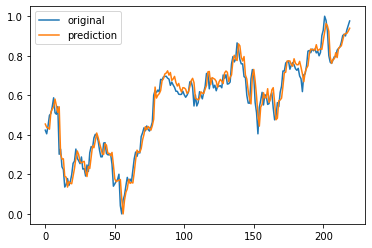

In [24]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()